### Imports Librerías

In [5]:
# TF 2.13
import tensorflow as tf
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import numpy as np
import math

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.applications.efficientnet_v2 as effnV2
from tensorflow.keras.layers import Dense, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout
from sklearn.utils.class_weight import compute_class_weight

In [28]:
class HistoryAndPlotCallback(Callback):
    def __init__(self, model_name):
        super(HistoryAndPlotCallback, self).__init__()
        self.model_name = model_name

    def on_train_end(self, logs=None):
        # Guardar el historial del modelo
        history = self.model.history.history

        # Calcular límite eje Y
        loss_av = np.average(history["loss"][-1])
        val_loss_av = np.average(history["val_loss"][-1])
        acc_av = np.average(history["acc"][-1])
        val_acc_av = np.average(history["val_acc"][-1])
        y_upper_limit = np.max([loss_av, val_loss_av, acc_av, val_acc_av])
        y_upper_limit *= 2

        np.save(f'models/{self.model_name}/training_history.npy', history)

        # Guardar métricas y pérdidas en una sola gráfica
        epochs = len(history["loss"])
        
        plt.style.use("ggplot")
        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(0, epochs), history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history["acc"], label="train_acc")
        plt.plot(np.arange(0, epochs), history["val_acc"], label="val_acc")
        
        plt.title(f"Training Loss and Accuracy - {self.model_name}")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc='upper left')
        plt.ylim(0, int(y_upper_limit))
        plt.grid(True)
        
        # Guardar la gráfica
        plt.savefig(f'models/{self.model_name}/training_plot.png')
        plt.close()

        # Guardar history para revisar en el futuro por si se activa un earlystopping o cualquier problema
        pd.DataFrame.from_dict(history).to_csv(f'models/{self.model_name}/history.csv', index=False)


def get_callbacks(model_name):
    callbacks = [
        EarlyStopping(
            monitor = 'val_loss', 
            mode = 'min', 
            patience = 7, 
            verbose=1,
            restore_best_weights=False),
        ModelCheckpoint(
            filepath = f'models/{model_name}',
            monitor = 'val_loss',
            mode = 'min',
            save_best_only = True,
            verbose = 1),
        HistoryAndPlotCallback(model_name),

    ]
        
    return callbacks

### Definición metodos creación del dataset

In [8]:
dict_map_class = {
    'Loose Silky-bent': 0,
    'Common Chickweed': 1,
    'Scentless Mayweed': 2,
    'Small-flowered Cranesbill': 3,
    'Fat Hen': 4,
    'Charlock': 5,
    'Sugar beet': 6,
    'Cleavers': 7,
    'Black-grass': 8,
    'Shepherds Purse': 9,
    'Common wheat': 10,
    'Maize': 11,   
}

dict_map_class_inverted = {v: k for k, v in dict_map_class.items()}

def get_dict_dataset(
    dataset_path: str = 'dataset'
):
    """
    Creates a dictionary mapping image paths to tuples containing class and partition.

    Args:
        dataset_path (str): Path to the dataset directory. Defaults to 'dataset'.

    Returns:
        dict: A dictionary where keys are image paths and values are tuples (class, partition).
    """

    dict_dataset = {}

    train_classes = os.listdir(os.path.join(dataset_path, 'train'))

    for train_class in train_classes:
        class_path = os.path.join(dataset_path, 'train', train_class)
        train_imgs = os.listdir(class_path)
        
        # Split Train images to a 80% for a Train Split for each class
        for train_img in train_imgs[:int(len(train_imgs)*0.8)]:
            train_img_path = os.path.join(class_path, train_img)
            dict_dataset[train_img_path] = (dict_map_class[train_class], 'Train')

        # Assign the rest 20% to Valid Split for each class
        for valid_img in train_imgs[int(len(train_imgs)*0.8):]:
            valid_img_path = os.path.join(class_path, valid_img)
            dict_dataset[valid_img_path] = (dict_map_class[train_class], 'Valid')

    # Geting Test Images
    test_path = os.path.join(dataset_path, 'test')
    test_imgs = os.listdir(test_path)

    for test_img in test_imgs:
        test_img_path = os.path.join(test_path, test_img)
        dict_dataset[test_img_path] = ("Unkown", 'Test')

    return dict_dataset


def dict2dataframe(
    input_dict: Dict[str, Tuple]
):
    """
    Converts a dictionary to a pandas DataFrame with columns for 'path', 'label', and 'split'.

    Args:
        input_dict (dict): A dictionary where keys are image paths and values are tuples (label, split).

    Returns:
        pd.DataFrame: A DataFrame with columns 'path', 'label', and 'split'.
    """
    df = pd.DataFrame([(key, values[0], values[1]) for key, values in input_dict.items()], columns=['path', 'label', 'split'])

    # Returns shuffled datasets
    return df.sample(frac=1, random_state=42).reset_index(drop=True)


### Definición modelos prueba

In [29]:
def load_efficienNetV2(
    num_classes = int,
    imagenet_weights = bool,
):
    """
    Loads EfficientNetV2 model with customized top layers for a specific number of classes.

    Args:
        num_classes (int): Number of classes for the final classification layer.

    Returns:
        tf.keras.models.Model: An instance of the EfficientNetV2 model with customized top layers.
    """
    if imagenet_weights:
        print(' > Loading iamgenet weights')
        weights_name = 'imagenet'
    else:
        weights_name =None

    redEffi = effnV2.EfficientNetV2B0(
        include_top=False,
        weights=weights_name,
        input_shape=(224, 224, 3),
    )

    x = redEffi.outputs[0]
    x_mean = GlobalAveragePooling2D()(x)
    x_max = GlobalMaxPooling2D()(x)
    x = Concatenate()([x_mean, x_max])
    x = Dropout(0.3)(x)

    x = Dense(num_classes, activation = 'softmax')(x)

    model = tf.keras.models.Model(
            inputs=redEffi.inputs, outputs=[x])

    return model

### Creacion TF Datasets

In [10]:
def tf_augmenter():
    """
    Returns a TensorFlow function for data augmentation.

    The returned function applies random transformations to the input images,
    including random flips (up-down and left-right), random brightness adjustments,
    and random contrast adjustments.

    Returns:
        callable: A TensorFlow function that takes a variable number of arguments (tensors)
                  representing the dataset and applies data augmentation to the images.
    """
    @tf.function
    def f(*dataset):
        output= list(dataset)
        image = output[0]
        
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_up_down(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_left_right(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_brightness(image, 0.15)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.7:
            image = tf.image.random_contrast(image, 0.6, 1.4)

        output[0] = image
        return output
    return f


@tf.function
def load_image(*inputs):
    """
    TensorFlow function to load an image using a numpy function.

    Args:
        *inputs: Variable number of input tensors.

    Returns:
        list: A list of output tensors with the loaded image as the first element.
    """
    outputs = list(inputs)
    image = tf.numpy_function(load_image_np, [inputs[0]], tf.float32)
    image.set_shape([None, None, 3])
    outputs[0] = image
    
    return outputs


def load_image_np(path):
    """
    Loads an image from the specified path and convert it to a NumPy array.

    Args:
        path (str): The path to the image file.

    Returns:
        np.ndarray: A NumPy array representing the loaded image in RGB format.
    """
    return np.array(Image.open(path).convert('RGB')).astype(np.float32)


def resize(index=0, resize_to=None):
    """
    Returns a TensorFlow function to resize an image in a dataset.

    Args:
        index (int): Index of the image tensor in the dataset. Defaults to 0.
        resize_to (tuple or list or None): Target size for resizing. If None, no resizing is performed. Defaults to None.

    Returns:
        callable: A TensorFlow function that resizes the image in the dataset.
    """
    def f(*dataset):
        output = list(dataset)
        resized_image = tf.image.resize(dataset[index], resize_to)
        resized_image = tf.cast(resized_image, tf.uint8)
        output[index] = resized_image
        
        return output
    return f


def preprocess_input(index):
    """
    Returns a TensorFlow function to preprocess an image in a dataset.

    Args:
        index (int): Index of the image tensor in the dataset.

    Returns:
        callable: A TensorFlow function that preprocesses the image in the dataset.
    """
    @tf.function
    def f(*dataset):
        output = list(dataset)
        image = dataset[index]
        image = tf.cast(image, tf.float32)
        image = image / 255.
        output[index] = image
        
        return output
    return f

In [11]:
def get_dataset(
    df: pd.DataFrame,
    input_size: Tuple[int, int],
    shuffle: bool = False,
    batch_size: int = None,
    gray_scale: bool = False,
    augmenter: bool = False,
    num_aug: int = None,
    test_set: bool = False
)->tf.data.Dataset:
    """
    Creates a TensorFlow dataset from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing information about the dataset.
        input_size (Tuple[int, int]): Tuple representing the target size for image resizing.
        shuffle (bool): Whether to shuffle the dataset. Defaults to False.
        batch_size (int): Batch size for the dataset. If None, no batching is performed. Defaults to None.
        gray_scale (bool): Whether to convert images to grayscale. Defaults to False.
        augmenter (bool): Whether to apply data augmentation. Defaults to False.
        num_aug (int): Number of augmentations to apply if augmenter is True. Defaults to None.
        test_set (bool): Whether the dataset is a test set. Defaults to False.

    Returns:
        tf.data.Dataset: A TensorFlow dataset prepared based on the provided options.
    """
    # Prints info about labels distribution 
    print('Number of instances per label: ',
          pd.Series(df['label']).value_counts(), sep='\n')
    print('\nPercentaje of instances per label: ',
          pd.Series(df['label']).value_counts().div(pd.Series(df['label']).shape[0]),
          sep='\n')

    names = np.array(df['path'], dtype=str)

    if not test_set:
        labels = np.array(tf.keras.utils.to_categorical(df['label'], num_classes=12))
    else:
        labels = np.ones(len(names))

    data = names, labels

    # Creates a tf dataset from paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Shuffles the entire dataset
    if shuffle:
        print(' > Shuffle')
        dataset = dataset.shuffle(len(names))

    # Loading Images
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Resize to desired size
    dataset = dataset.map(resize(resize_to=input_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Augmentation
    if augmenter:
        print(f' > Augmentamos datos numero {num_aug}')
        if num_aug == 1:
            dataset = dataset.map(tf_augmenter(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Preprocessing input
    dataset = dataset.map(preprocess_input(0), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Converts to gray Scale
    if gray_scale:
        print(' > Escala de grises')
        dataset = dataset.map(lambda *args: (tf.image.rgb_to_grayscale(args[0]), *args[1:]))

    # Prepare batch_size
    if batch_size is not None:
        print(' > Establecemos el batchsize')
        dataset = dataset.batch(batch_size)
    
    # Prefetch to overlap data preprocessing and model execution
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## **Creamos los DataFrames con el contenido de nuestro dataset**

In [12]:
dict_dataset = get_dict_dataset(dataset_path="../dataset/")

# Creamos el DataFrame 
df_dataset = dict2dataframe(dict_dataset)
df_dataset

,path,label,split
0,../dataset/train\Scentless Mayweed\8c496e84a.png,2,Train
1,../dataset/train\Common wheat\4a56f32c6.png,10,Train
2,../dataset/test\99569b224.png,Unkown,Test
3,../dataset/train\Black-grass\e0380dff9.png,8,Valid
4,../dataset/train\Fat Hen\9708f9c0e.png,4,Train
...,...,...,...
5539,../dataset/train\Shepherds Purse\953ced7c6.png,9,Train
5540,../dataset/test\8cf909eb3.png,Unkown,Test
5541,../dataset/test\98062cd87.png,Unkown,Test
5542,../dataset/test\cc3d2a59a.png,Unkown,Test


In [13]:
df_dataset['label'].value_counts()

label
Unkown    794
0         654
1         611
2         516
3         496
4         475
5         390
6         385
7         287
8         263
9         231
10        221
11        221
Name: count, dtype: int64

In [14]:
df_dataset_train = df_dataset[df_dataset['split'] == 'Train'].drop(columns=['split'])
df_dataset_train

,path,label
0,../dataset/train\Scentless Mayweed\8c496e84a.png,2
1,../dataset/train\Common wheat\4a56f32c6.png,10
4,../dataset/train\Fat Hen\9708f9c0e.png,4
5,../dataset/train\Sugar beet\6d623072a.png,6
8,../dataset/train\Small-flowered Cranesbill\869...,3
...,...,...
5534,../dataset/train\Scentless Mayweed\948251df3.png,2
5535,../dataset/train\Sugar beet\29a0e6bf9.png,6
5537,../dataset/train\Charlock\8b35222d0.png,5
5539,../dataset/train\Shepherds Purse\953ced7c6.png,9


In [15]:
df_dataset_train['label'].value_counts()

label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

In [16]:
df_dataset_valid = df_dataset[df_dataset['split'] == 'Valid'].drop(columns=['split'])
df_dataset_valid

,path,label
3,../dataset/train\Black-grass\e0380dff9.png,8
10,../dataset/train\Scentless Mayweed\d748c7307.png,2
15,../dataset/train\Fat Hen\e6b756e98.png,4
22,../dataset/train\Small-flowered Cranesbill\ecf...,3
24,../dataset/train\Charlock\d1b362c43.png,5
...,...,...
5500,../dataset/train\Loose Silky-bent\fc2b27fff.png,0
5501,../dataset/train\Charlock\fc3e15a2e.png,5
5503,../dataset/train\Scentless Mayweed\d1e775b97.png,2
5505,../dataset/train\Common Chickweed\f50c8181a.png,1


In [17]:
df_dataset_valid['label'].value_counts()

label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

In [18]:
df_dataset_test = df_dataset[df_dataset['split'] == 'Test'].drop(columns=['split'])
df_dataset_test

,path,label
2,../dataset/test\99569b224.png,Unkown
6,../dataset/test\d14aa43f3.png,Unkown
7,../dataset/test\b47691c08.png,Unkown
12,../dataset/test\19fdf19fb.png,Unkown
14,../dataset/test\7d4cd07ad.png,Unkown
...,...,...
5526,../dataset/test\b30ab4659.png,Unkown
5536,../dataset/test\bb1c84bbc.png,Unkown
5540,../dataset/test\8cf909eb3.png,Unkown
5541,../dataset/test\98062cd87.png,Unkown


In [19]:
df_dataset_test['label'].value_counts()

label
Unkown    794
Name: count, dtype: int64

### Visualizamos muestras random del dataset

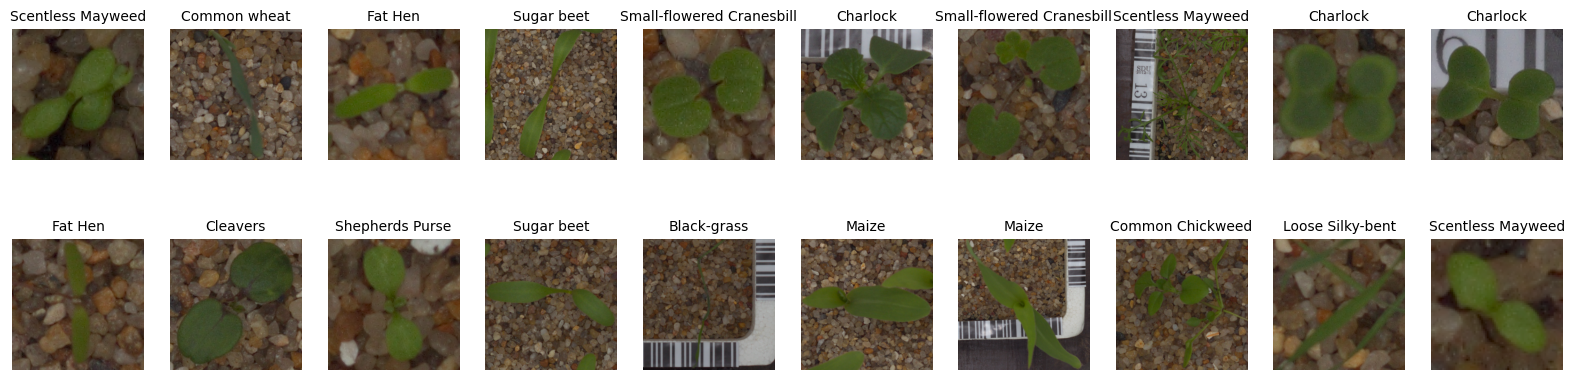

In [20]:
fig = plt.figure(figsize = (20, 5))

for i in range(20):
    img = Image.open(df_dataset_train.iloc[i]['path'])
    ax = fig.add_subplot(2, 10, i + 1)
    ax.imshow(img.convert('RGB'))
    title = dict_map_class_inverted[df_dataset_train.iloc[i]['label']]
    ax.set_title(title, fontsize=10)
    ax.axis('off')

## **Creamos los datasets para train, val y test**

In [21]:
train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)

train_tfdataset

Number of instances per label: 
label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: count, dtype: float64
 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [22]:
valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Number of instances per label: 
label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: count, dtype: float64
 > Shuffle
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [23]:
test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=32,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Number of instances per label: 
label
Unkown    794
Name: count, dtype: int64

Percentaje of instances per label: 
label
Unkown    1.0
Name: count, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Visualizamos los datasets preparado

No hacer si luego vamos a lanzar un entrenamiento, porque se iterar'an y al entrenar algunas muestras no estar;an y creo que va

In [ ]:
# TRAIN
batch = next(iter(train_tfdataset))
print
batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [ ]:
# VAL
batch = next(iter(valid_tfdataset))
print
batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [ ]:
# TEST
batch = next(iter(test_tfdataset))
print
batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

## **Prueba entrenamiento**

In [24]:
# Calculamos los pesos de cada clase debido al desbalanceo de las clases
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df_dataset_train['label'].values),
                                     y=df_dataset_train['label'].values
)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.6045251752708731,
 1: 0.6478825136612022,
 2: 0.7673948220064725,
 3: 0.7984006734006734,
 4: 0.8320175438596491,
 5: 1.0133547008547008,
 6: 1.0265151515151516,
 7: 1.3806404657933042,
 8: 1.5055555555555555,
 9: 1.7182971014492754,
 10: 1.7964015151515151,
 11: 1.7964015151515151}

In [25]:
!pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\alvar\anaconda3\envs\tf\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [30]:
# Cargamos el modelo de prueba
model = load_efficienNetV2(
    num_classes=12,
    imagenet_weights=True)

model.summary()

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = ['acc']) 

callbacks = get_callbacks("efficintB0_cw_imagenet")

# Entrenamos el modelo
history = model.fit(train_tfdataset.repeat(),
        validation_data=valid_tfdataset,
        class_weight = class_weight_dict,
        epochs = 50,
        steps_per_epoch=50,
        callbacks = callbacks,
        verbose=1)


 > Loading iamgenet weights
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864   

INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 148s 3s/step - loss: 4.4812 - acc: 0.1256 - val_loss: 3.5915 - val_acc: 0.1088
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 2.9424 - acc: 0.2544
Epoch 2: val_loss improved from 3.59153 to 2.28200, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 130s 3s/step - loss: 2.9424 - acc: 0.2544 - val_loss: 2.2820 - val_acc: 0.2981
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 2.0486 - acc: 0.3897
Epoch 3: val_loss improved from 2.28200 to 1.90023, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 129s 3s/step - loss: 2.0486 - acc: 0.3897 - val_loss: 1.9002 - val_acc: 0.3630
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 1.5630 - acc: 0.5250
Epoch 4: val_loss improved from 1.90023 to 0.72259, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 130s 3s/step - loss: 1.5630 - acc: 0.5250 - val_loss: 0.7226 - val_acc: 0.7458
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 1.2692 - acc: 0.5984
Epoch 5: val_loss did not improve from 0.72259
50/50 [==============================] - 114s 2s/step - loss: 1.2692 - acc: 0.5984 - val_loss: 1.0895 - val_acc: 0.6318
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.9674 - acc: 0.6819
Epoch 6: val_loss did not improve from 0.72259
50/50 [==============================] - 115s 2s/step - loss: 0.9674 - acc: 0.6819 - val_loss: 0.7446 - val_acc: 0.7395
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 0.8878 - acc: 0.6988
Epoch 7: val_loss did not improve from 0.72259
50/50 [==============================] - 115s 2s/step - loss: 0.8878 - acc: 0.6988 - val_loss: 1.2229 - val_acc: 0.5628
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 0.7413 - acc: 0.7478
Epoch 8: val_loss did n

INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 132s 3s/step - loss: 0.6625 - acc: 0.7713 - val_loss: 0.6423 - val_acc: 0.7699
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.5614 - acc: 0.7982
Epoch 10: val_loss improved from 0.64226 to 0.34639, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 131s 3s/step - loss: 0.5614 - acc: 0.7982 - val_loss: 0.3464 - val_acc: 0.8734
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.4982 - acc: 0.8238
Epoch 11: val_loss did not improve from 0.34639
50/50 [==============================] - 120s 2s/step - loss: 0.4982 - acc: 0.8238 - val_loss: 0.6003 - val_acc: 0.7699
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.4933 - acc: 0.8253
Epoch 12: val_loss did not improve from 0.34639
50/50 [==============================] - 118s 2s/step - loss: 0.4933 - acc: 0.8253 - val_loss: 0.5269 - val_acc: 0.7835
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 0.4365 - acc: 0.8419
Epoch 13: val_loss did not improve from 0.34639
50/50 [==============================] - 118s 2s/step - loss: 0.4365 - acc: 0.8419 - val_loss: 0.3903 - val_acc: 0.8609
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 0.3857 - acc: 0.8506
Epoch 14: val_lo

INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 134s 3s/step - loss: 0.3286 - acc: 0.8850 - val_loss: 0.3376 - val_acc: 0.8808
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.3153 - acc: 0.8758
Epoch 17: val_loss improved from 0.33762 to 0.20352, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 133s 3s/step - loss: 0.3153 - acc: 0.8758 - val_loss: 0.2035 - val_acc: 0.9268
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.2895 - acc: 0.8944
Epoch 18: val_loss did not improve from 0.20352
50/50 [==============================] - 115s 2s/step - loss: 0.2895 - acc: 0.8944 - val_loss: 0.2415 - val_acc: 0.9142
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.3004 - acc: 0.8888
Epoch 19: val_loss did not improve from 0.20352
50/50 [==============================] - 115s 2s/step - loss: 0.3004 - acc: 0.8888 - val_loss: 0.4898 - val_acc: 0.8264
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 0.2390 - acc: 0.9061
Epoch 20: val_loss improved from 0.20352 to 0.19889, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 130s 3s/step - loss: 0.2390 - acc: 0.9061 - val_loss: 0.1989 - val_acc: 0.9236
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 0.2616 - acc: 0.9056
Epoch 21: val_loss did not improve from 0.19889
50/50 [==============================] - 119s 2s/step - loss: 0.2616 - acc: 0.9056 - val_loss: 0.4719 - val_acc: 0.8243
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.2263 - acc: 0.9130
Epoch 22: val_loss did not improve from 0.19889
50/50 [==============================] - 118s 2s/step - loss: 0.2263 - acc: 0.9130 - val_loss: 0.3423 - val_acc: 0.8787
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.2463 - acc: 0.9056
Epoch 23: val_loss did not improve from 0.19889
50/50 [==============================] - 118s 2s/step - loss: 0.2463 - acc: 0.9056 - val_loss: 0.3327 - val_acc: 0.8849
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.2452 - acc: 0.8934
Epoch 24: val_lo

In [ ]:
predictions = model.predict(test_tfdataset)

In [31]:
# Cargamos el modelo de prueba
model = load_efficienNetV2(
    num_classes=12,
    imagenet_weights=False)

model.summary()

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = ['acc']) 

callbacks = get_callbacks("efficintB0_cw_no_preweights")

# Entrenamos el modelo
history = model.fit(train_tfdataset.repeat(),
        validation_data=valid_tfdataset,
        class_weight = class_weight_dict,
        epochs = 50,
        steps_per_epoch=50,
        callbacks = callbacks,
        verbose=1)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization_3[0][0]'

INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


50/50 [==============================] - 148s 3s/step - loss: 3.5951 - acc: 0.0750 - val_loss: 2.5528 - val_acc: 0.1088
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 3.4230 - acc: 0.0869
Epoch 2: val_loss did not improve from 2.55283
50/50 [==============================] - 114s 2s/step - loss: 3.4230 - acc: 0.0869 - val_loss: 2.5835 - val_acc: 0.1318
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 3.4022 - acc: 0.0933
Epoch 3: val_loss did not improve from 2.55283
50/50 [==============================] - 118s 2s/step - loss: 3.4022 - acc: 0.0933 - val_loss: 2.6059 - val_acc: 0.1088
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 3.2689 - acc: 0.0806
Epoch 4: val_loss improved from 2.55283 to 2.52495, saving model to models\efficintB0_cw_no_preweights
INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


50/50 [==============================] - 131s 3s/step - loss: 3.2689 - acc: 0.0806 - val_loss: 2.5250 - val_acc: 0.1015
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 3.2517 - acc: 0.0971
Epoch 5: val_loss did not improve from 2.52495
50/50 [==============================] - 118s 2s/step - loss: 3.2517 - acc: 0.0971 - val_loss: 2.7089 - val_acc: 0.1276
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 3.1592 - acc: 0.0831
Epoch 6: val_loss improved from 2.52495 to 2.49458, saving model to models\efficintB0_cw_no_preweights
INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


50/50 [==============================] - 133s 3s/step - loss: 3.1592 - acc: 0.0831 - val_loss: 2.4946 - val_acc: 0.1025
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 3.1044 - acc: 0.0994
Epoch 7: val_loss did not improve from 2.49458
50/50 [==============================] - 115s 2s/step - loss: 3.1044 - acc: 0.0994 - val_loss: 2.5480 - val_acc: 0.0617
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 3.1955 - acc: 0.0933
Epoch 8: val_loss improved from 2.49458 to 2.48470, saving model to models\efficintB0_cw_no_preweights
INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_no_preweights\assets


50/50 [==============================] - 134s 3s/step - loss: 3.1955 - acc: 0.0933 - val_loss: 2.4847 - val_acc: 0.0858
Epoch 9/50
14/50 [=======>......................] - ETA: 1:21 - loss: 3.1369 - acc: 0.1094